In [33]:
import cv2 #opencv读取的格式是BGR
import numpy as np
import matplotlib.pyplot as plt#Matplotlib是RGB
%matplotlib inline 

In [34]:
def cv_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

### 直方图

- 直方图横坐标代表像素数目，纵坐标代表每个像素数目对应的统计个数


![title](hist_1.png)

#### cv2.calcHist(images,channels,mask,histSize,ranges)

- images： 原图像图像格式为 uint8 或 ﬂoat32。当传入函数时应 用中括号 [] 括来例如[img]
- channels： 同样用中括号括来它会告函数我们统幅图 像的直方图。如果入图像是灰度图它的值就是 [0]如果是彩色图像 的传入的参数可以是 [0][1][2] 它们分别对应着 BGR（在OpenCV中的图像顺序不是RGB，而是BGR）。 
- mask：掩模图像。统整幅图像的直方图就把它为 None。但是如 果你想统图像某一分的直方图的你就制作一个掩模图像并 使用它。
- histSize：BIN 的数目。也应用中括号括来
- ranges： 像素值范围常为 [0,256] 。OpenCV的ranges参数涉及为*左闭右开区间，实际覆盖为0~255*

In [ ]:
# 0表示灰度图，相当于 img=cv2.imread("cat.jpg",cv2.IMREAD_GRAYSCALE) 。 0和cv2.IMREAD_GRAYSCALE等价
img = cv2.imread('cat.jpg',0)
# 第一个参数：img必须手动加上[]，列表形式
# 第二个参数：[0]获取第0个通道，因为这个转换为了灰度图，所以就存在一个通道
# 第三个参数：None不指定掩模图像，统计整个图的像素点
# 第四个参数：横坐标直方图bin数量（256对应0~255的每个值）
# 第五个参数：像素值取值范围
hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist.shape

In [ ]:
plt.hist(img.ravel(),256); 
plt.show()

In [ ]:
img = cv2.imread('cat.jpg') 
color = ('b','g','r')
for i,col in enumerate(color): 
    histr = cv2.calcHist([img],[i],None,[256],[0,256]) 
    plt.plot(histr,color = col) 
    plt.xlim([0,256]) 


mask操作

In [ ]:
# 创建mask，这个mask的尺寸必须和覆盖的原始图像尺寸一致
# 初始化使用 np.zeros() 将像素点全部设置为0，纯黑色
mask = np.zeros(img.shape[:2], np.uint8)
print (mask.shape)
# OpenCV中的mask想展示哪个地方就将哪个地方的像素值置为255
mask[100:300, 100:400] = 255
cv_show(mask,'mask')

In [ ]:
img = cv2.imread('cat.jpg', 0)
cv_show(img,'img')

In [ ]:
# 提取目标区域像素：将二值图 thresh 与掩膜 mask 结合，像素之间进行与操作，一零则零。
masked_img = cv2.bitwise_and(img, img, mask=mask)
cv_show(masked_img,'masked_img')

In [ ]:
hist_full = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_mask = cv2.calcHist([img], [0], mask, [256], [0, 256])

In [ ]:
plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.imshow(mask, 'gray')
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0, 256])
plt.show()

#### 直方图均衡化

![title](hist_2.png)

![title](hist_3.png)

![title](hist_4.png)

In [ ]:
img = cv2.imread('clahe.jpg',0) #0表示灰度图 #clahe
plt.hist(img.ravel(),256); 
plt.show()

In [ ]:
# 均衡化操作
equ = cv2.equalizeHist(img) 
plt.hist(equ.ravel(),256)
plt.show()


In [ ]:
res = np.hstack((img,equ))
cv_show(res,'res')

#### 自适应直方图均衡化

In [ ]:
# 创建自适应均衡化
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 

In [ ]:
# 原始图片应用自适应均衡化
res_clahe = clahe.apply(img)
res = np.hstack((img,equ,res_clahe))
cv_show(res,'res')

### 模板匹配


模板匹配和卷积原理很像，模板在原图像上从原点开始滑动（从左到右，从下到下），计算模板与（图像被模板覆盖的地方）的差别程度，这个差别程度的计算方法在opencv里有6种，然后将每次计算的结果放入一个矩阵里，作为结果输出。假如原图形是AxB大小，而模板是axb大小，则输出结果的矩阵是(A-a+1)x(B-b+1)


模板匹配核心：
- 必须将模板(roi)和待检测目标的尺寸统一调整为相同的固定值（如57X88），如果模板和目标的尺寸不同，即使内容完全一致，cv2.matchTemplate() 这类函数也无法正确匹配（数学上无法对齐像素矩阵）。

工作原理可视化：
模板制作：模板制作（统一尺寸） → 模板库中的每个字符均为 57x88
目标检测：待检测区域 → 裁剪 → 缩放为57x88 → 和模板逐个比对

若目标未缩放直接匹配，算法会因尺寸差异直接返回低置信度（甚至误判）。

In [4]:
# 模板匹配
img = cv2.imread('lena.jpg', 0)
template = cv2.imread('face.jpg', 0)
h, w = template.shape[:2] 

In [5]:
img.shape

(263, 263)

In [6]:
template.shape

(110, 85)

- TM_SQDIFF：计算平方不同，计算出来的值越小，越相关        
- TM_CCORR：计算相关性，计算出来的值越大，越相关
- TM_CCOEFF：计算相关系数，计算出来的值越大，越相关
- TM_SQDIFF_NORMED：计算归一化平方不同，计算出来的值越接近0，越相关
- TM_CCORR_NORMED：计算归一化相关性，计算出来的值越接近1，越相关
- TM_CCOEFF_NORMED：计算归一化相关系数，计算出来的值越接近1，越相关



公式：https://docs.opencv.org/3.3.1/df/dfb/group__imgproc__object.html#ga3a7850640f1fe1f58fe91a2d7583695d

In [7]:
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

In [8]:
res = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)
res.shape

(154, 179)

In [9]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

In [10]:
min_val

39168.0

In [11]:
max_val

74403584.0

In [12]:
min_loc

(107, 89)

In [13]:
max_loc

(159, 62)

4
-831154.6875
819162.0
(186, 43)
(220, 15)


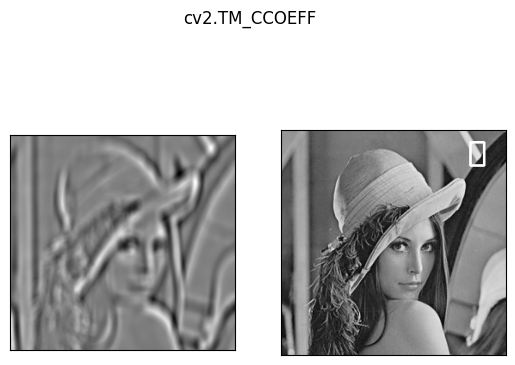

5
-0.6372358202934265
0.6006510853767395
(202, 231)
(0, 202)


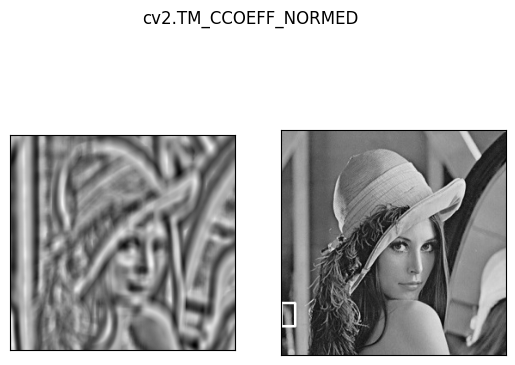

2
649328.9375
3205787.0
(85, 234)
(230, 178)


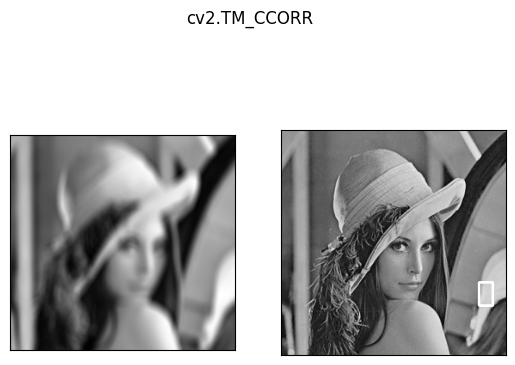

3
0.2213945984840393
0.6956493258476257
(186, 42)
(0, 202)


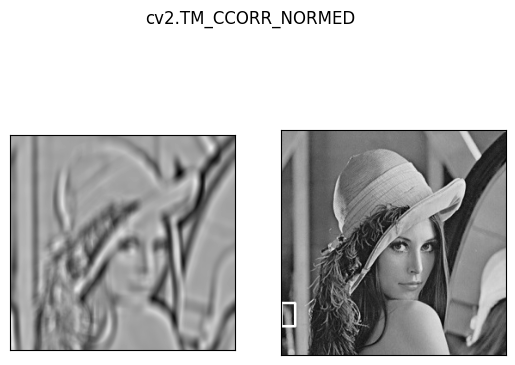

0
1430367.75
14591509.0
(192, 106)
(235, 173)


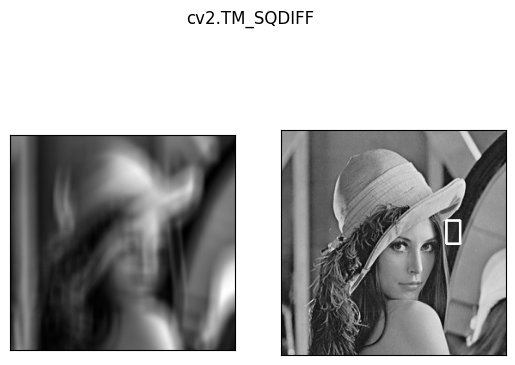

1
0.7982704639434814
1.0
(175, 181)
(0, 0)


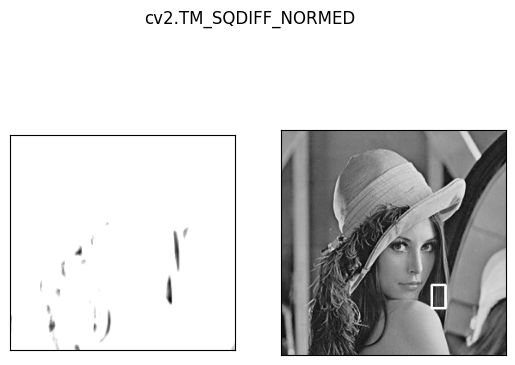

In [20]:
for meth in methods:
    img2 = img.copy()

    # 匹配方法的真值
    method = eval(meth)
    print (method)
    res = cv2.matchTemplate(img, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # 如果是平方差匹配TM_SQDIFF或归一化平方差匹配TM_SQDIFF_NORMED，取最小值
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # 画矩形
    cv2.rectangle(img2, top_left, bottom_right, 255, 2)

    plt.subplot(121), plt.imshow(res, cmap='gray')
    plt.xticks([]), plt.yticks([])  # 隐藏坐标轴
    plt.subplot(122), plt.imshow(img2, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

### 匹配多个对象

In [17]:
img_rgb = cv2.imread('mario.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('mario_coin.jpg', 0)
h, w = template.shape[:2]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
# 匹配多个对象和匹配一个对象的区别就在于：
# 匹配单个对象只需要根据使用的匹配算法计算获取最大值或最小值即可
# 匹配多个对象需要设定一个阈值，当获取到的匹配结果大于这个阈值后，都认为是匹配成功
threshold = 0.8
# 取匹配程度大于%80的坐标
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):  # *号表示可选参数
    bottom_right = (pt[0] + w, pt[1] + h)
    cv2.rectangle(img_rgb, pt, bottom_right, (0, 0, 255), 2)

cv2.imshow('img_rgb', img_rgb)
cv2.waitKey(0)

(array([ 40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  41,  41,  41,
        41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  42,
        42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
        43,  43,  43,  43,  43,  72,  72,  72,  72,  72,  72,  72,  72,
        72,  72,  72,  72,  72,  73,  73,  73,  73,  73,  73,  73,  73,
        73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
        74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,
        74,  74,  74,  74,  74,  74,  74,  75,  75,  75,  75,  75,  75,
        75, 104, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106,
       106, 106, 106], dtype=int64), array([ 69,  70,  83,  84,  97,  98, 111, 112, 125, 126,  68,  69,  70,
        82,  83,  84,  96,  97,  98, 110, 111, 112, 124, 125, 126,  68,
        69,  70,  82,  83,  84,  96,  97,  98, 110, 111, 112, 125, 126,
        69,  83,  97, 111, 125,  54,  55,  69,  83,  84,  97,  98, 111,
       112, 125, 126, 139,

-1